In [2]:
%load_ext autoreload
%autoreload 2
import os
import jax.numpy as jnp

# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Use GPU 1
import functools
import jax
# jax.config.update("jax_enable_x64", True)

import mujoco
from mujoco import mjx

from dm_control import mjcf
from dm_control.locomotion.walkers import rescale
from dm_control.mujoco.wrapper.mjbindings import enums
from typing import Dict
from brax import envs
import mujoco
import pickle
import warnings
import mediapy as media
import hydra
import h5py
import jax.numpy as jp
import numpy as np
import imageio
import matplotlib.pyplot as plt
from typing import List, Union
from pathlib import Path
from omegaconf import DictConfig, OmegaConf
import matplotlib.pyplot as plt
from tqdm import tqdm
import brax.math as brax_math
warnings.filterwarnings("ignore", category=DeprecationWarning)
# jax.config.update("jax_enable_x64", True)

from hydra import initialize, compose
from hydra.core.hydra_config import HydraConfig
from hydra.core.global_hydra import GlobalHydra
from pathlib import Path

import time
import mediapy as media

import numpy as np
import matplotlib.pyplot as plt
import cv2
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

from IPython.display import clear_output
clear_output()

In [ ]:
import jax
print(jax.default_backend())  # Should return "gpu"
print(jax.devices())  # Should list GPU devices

gpu
[CudaDevice(id=0)]


In [4]:
import matplotlib
print(matplotlib.__version__, matplotlib.get_backend())

3.10.0 module://matplotlib_inline.backend_inline


#### Code based off Charles and Elliot's code! Nothing here is really mine

In [5]:
mjcf_path = 'configs/model/arm_model_v3_torque.xml'
mjcf_element = mjcf.from_path(mjcf_path)
physics = mjcf.Physics.from_mjcf_model(mjcf_element)
mj_data = mujoco.MjData(physics.model.ptr)

In [6]:
for i in range(10):
    for j in range(20):
        a = physics.model.id2name(i, j)
        if a: print(f'{i, j} {a}')

(0, 1) world
(0, 2) world
(0, 3) sh_elv
(0, 5) //unnamed_geom_0
(0, 7) my_camera
(0, 8) //unnamed_light_0
(0, 10) Bone_Scapula_right_v3
(0, 13) //unnamed_texture_0
(0, 14) grid
(0, 19) sh_elv_act
(1, 1) ground
(1, 2) ground
(1, 3) sh_extension
(1, 5) //unnamed_geom_1
(1, 7) my_camera1
(1, 10) Bone_Humerus_right_v3
(1, 13) grid
(1, 19) sh_extension_act
(2, 1) clavicle
(2, 2) clavicle
(2, 3) sh_rotation
(2, 5) //unnamed_geom_2
(2, 10) Bone_Clavicle_right_v3
(2, 19) sh_rotation_act
(3, 1) scapula
(3, 2) scapula
(3, 3) elbow_joint
(3, 5) //unnamed_geom_3
(3, 10) Bone_Ulna_right_v3
(3, 19) elbow_act
(4, 1) humerus
(4, 2) humerus
(4, 5) elbow_marker
(4, 10) Bone_Radius_right_v3
(5, 1) ulna
(5, 2) ulna
(5, 5) //unnamed_geom_5
(5, 10) Bone_Segments_Hand
(6, 1) elbow
(6, 2) elbow
(6, 5) wrist_marker
(7, 1) radius
(7, 2) radius
(7, 5) //unnamed_geom_7
(8, 1) wrist_body
(8, 2) wrist_body
(9, 1) hand
(9, 2) hand


In [9]:
print(physics.model.name2id("wrist_body", "body"))
print(physics.model.name2id("scapula", "body"))
print(physics.model.name2id("elbow_marker", "geom"))

8
3
4


In [10]:
physics.named.model.body_pos
# physics.named.model.geom_pos
# physics.named.model.site_pos

FieldIndexer(body_pos):
                x         y         z         
 0      world [ 0         0         0       ]
 1     ground [ 0         0         0       ]
 2   clavicle [ 0         0         0       ]
 3    scapula [-0.0001   -0.0001    0.0005  ]
 4    humerus [ 0         0.0007   -0.0002  ]
 5       ulna [-0.0005    0.0003   -0.0068  ]
 6      elbow [ 0         0         0       ]
 7     radius [ 0.00035   0.0002    0.0002  ]
 8 wrist_body [-0.002     0.0065    0.0005  ]
 9       hand [ 0.005    -0.006    -0.009   ]

### Get the positions of hand, elbow, and scapula with dm_control mujoco

In [11]:
# step forward in the model
mujoco.mj_kinematics(physics.model.ptr, mj_data)

# get coordinates of the model
scapula_idx = physics.model.name2id('scapula', 'body')
scapula_pos = physics.data.xpos[scapula_idx]

elbow_idx = physics.model.name2id('elbow_marker', 'geom')
elbow_pos = physics.data.geom_xpos[elbow_idx]

hand_idx = physics.model.name2id('hand', 'body')
hand_pos = physics.data.xpos[hand_idx]

mujoco_arm_coords = np.vstack([scapula_pos, elbow_pos, hand_pos])
mujoco_arm_coords.shape

(3, 3)

In [12]:
np.concatenate([scapula_pos, elbow_pos, hand_pos]).shape

(9,)

In [20]:
with h5py.File("/root/vast/joshua/stac-mjx/tests/data/points3d_transformed_shorten.h5", 'r') as f:
    sleap_coords = f["tracks"][100][0]

In [21]:
# mujoco_arm_coords
sleap_coords

array([[ -7.06567338,   9.58399746,  13.09908705],
       [-10.62338103,  11.05285849,   4.78065169],
       [ -3.37341236,   9.77575084,   2.80209566]])

In [22]:
mujoco_arm_coords

array([[-0.0001    , -0.0001    ,  0.0005    ],
       [ 0.0011889 , -0.00413805, -0.00495372],
       [ 0.0064878 , -0.01083974, -0.00897384]])

In [23]:
def procrustes_jax(source_points, target_points, floor=None):
    """
    Perform Procrustes analysis to align matrix source_points to matrix target_points.
    
    Parameters:
    source_points : (N, M) array_like
        The source input matrix.
    target_points : (N, M) array_like
        The reference/target input matrix.
    kp_idxs: (N,) array_like
        The indices of the keypoints to use for the alignment.
    floor : float, optional
    
    Returns:
    d : float
        The residual sum of squared errors.
    Z : (T,N, M) ndarray
        The matrix Y, transformed to best match X.
    R : (M, M) ndarray
        The rotation applied to Y.
    scale : float
        The scaling factor applied to Y.
    """
    
    # Center both matrices
    source_centered = source_points - jp.mean(source_points, axis=0)
    target_centered = target_points - jp.mean(target_points, axis=0)

    # Normalize the Frobenius norm to 1
    target_norm = jp.linalg.norm(target_centered)
    source_norm = jp.linalg.norm(source_centered)
    target_centered /= target_norm
    source_centered /= source_norm

    # Compute the optimal rotation matrix using Singular Value Decomposition (SVD) for the first frame
    U, _, Vt = jp.linalg.svd(jp.dot(target_centered.T, source_centered).T)
    R = jp.dot(U, Vt)

    # Apply the rotation and scaling to all frames
    scale = target_norm / source_norm
    Z = jp.dot(source_points, R) * scale
    d = jp.sum(jp.square(target_centered - Z))

    return d, Z, R, scale

In [24]:
d, Z, R, scale = procrustes_jax(
    source_points=sleap_coords[0:2],
    target_points=mujoco_arm_coords[0:2])

In [25]:
Z

Array([[-0.00282584, -0.00641882,  0.0113478 ],
       [-0.00153695, -0.01045687,  0.00589408]], dtype=float32)

In [26]:
# 1) Center both matrices.
source_mean = jnp.mean(sleap_coords, axis=0)
target_mean = jnp.mean(mujoco_arm_coords, axis=0)

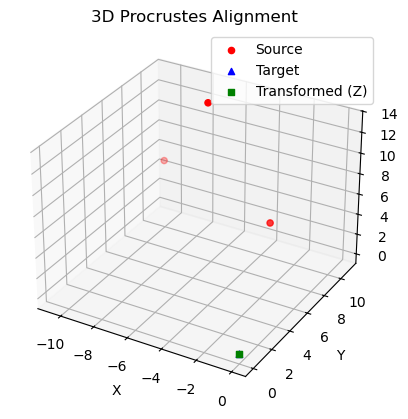

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D projection
from tqdm import tqdm

# Assume we already have these arrays of shape (N, 3):
#   source_points
#   target_points
#   Z (aligned version of source_points)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the points in 3D
ax.scatter(sleap_coords[:, 0], sleap_coords[:, 1], sleap_coords[:, 2],
           c='red', marker='o', label='Source')

ax.scatter(mujoco_arm_coords[:, 0], mujoco_arm_coords[:, 1], mujoco_arm_coords[:, 2],
           c='blue', marker='^', label='Target')

ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2],
           c='green', marker='s', label='Transformed (Z)')

# Set axes labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# Legend and show
ax.legend()
plt.title("3D Procrustes Alignment")
plt.show()


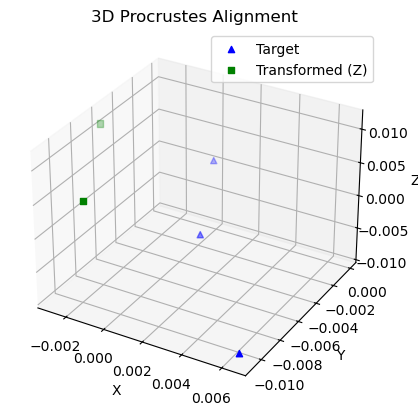

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D projection
from tqdm import tqdm

# Assume we already have these arrays of shape (N, 3):
#   source_points
#   target_points
#   Z (aligned version of source_points)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the points in 3D
# ax.scatter(sleap_coords[:, 0], sleap_coords[:, 1], sleap_coords[:, 2],
#            c='red', marker='o', label='Source')

ax.scatter(mujoco_arm_coords[:, 0], mujoco_arm_coords[:, 1], mujoco_arm_coords[:, 2],
           c='blue', marker='^', label='Target')

ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2],
           c='green', marker='s', label='Transformed (Z)')

# Set axes labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# Legend and show
ax.legend()
plt.title("3D Procrustes Alignment")
plt.show()


In [17]:
sleap_coords[0:2]

array([[ -7.06567338,   9.58399746,  13.09908705],
       [-10.62338103,  11.05285849,   4.78065169]])

In [18]:
# uses umeyama registration to find the optimal rotation, translation and scale factor for mapping from one space to another 
source_points=sleap_coords[0:2]
target_points=mujoco_arm_coords[0:2]

def umeyama(P, Q):
    assert P.shape == Q.shape
    n, dim = P.shape

    centeredP = P - P.mean(axis=0)
    centeredQ = Q - Q.mean(axis=0)

    C = np.dot(np.transpose(centeredP), centeredQ) / n

    V, S, W = np.linalg.svd(C)
    d = (np.linalg.det(V) * np.linalg.det(W)) < 0.0

    if d:
        S[-1] = -S[-1]
        V[:, -1] = -V[:, -1]

    R = np.dot(V, W)

    varP = np.var(P, axis=0).sum()
    c = 1/varP * np.sum(S) # scale factor

    t = Q.mean(axis=0) - P.mean(axis=0).dot(c*R)

    return c, R, t


c, R, t = umeyama(source_points, target_points)

# multiply the display box points using the rotation matrix, translation and sclaing factor generated from the umeyama function
aligned = source_points.dot(c*R) + t

# uses umeyama registration to find the optimal rotation, translation and scale factor for mapping from one space to another 
source_points=sleap_coords
target_points=mujoco_arm_coords

aligned = source_points.dot(c*R) + t

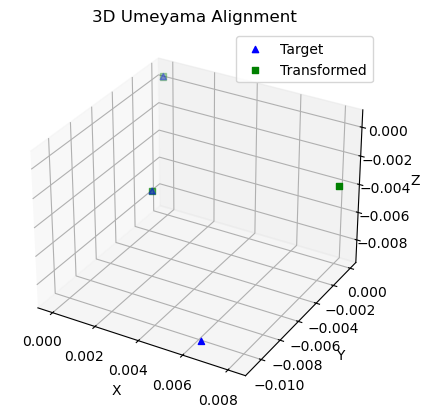

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D projection
from tqdm import tqdm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(target_points[:, 0], target_points[:, 1], target_points[:, 2],
           c='blue', marker='^', label='Target')

ax.scatter(aligned[:, 0], aligned[:, 1], aligned[:, 2],
           c='green', marker='s', label='Transformed')

# Set axes labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# Legend and show
ax.legend()
plt.title("3D Umeyama Alignment")
plt.show()


In [14]:
with h5py.File("./tests/data/points3d_transformed_shorten.h5", 'r') as f:
    full_sleap_coords = f["tracks"][:]

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = './tests/data/points3d_transformed_shorten.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [39]:
full_sleap_coords.shape


(1000, 1, 3, 3)

In [41]:
F, T, N, _ = full_sleap_coords.shape
aligned_all_frames = np.zeros_like(full_sleap_coords)

# Apply the transform to each frame using tqdm for progress
for i in tqdm(range(F), desc="Applying Umeyama transform to all frames"):
    # shape (N, 3) dot shape (3, 3) -> (N, 3)
    # Then multiply by scale 'c' and add translation 't'
    aligned_all_frames[i] = (full_sleap_coords[i].dot(R) * c) + t

Applying Umeyama transform to all frames: 100%|██████████| 1000/1000 [00:00<00:00, 84487.63it/s]


In [42]:
aligned_all_frames.shape

(1000, 1, 3, 3)

In [43]:
output_file = "mujoco_aligned_tracking.h5"
dataset_key = "tracks"
with h5py.File(output_file, "w") as hf:
        hf.create_dataset(dataset_key, data=aligned_all_frames)

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

# --------------------------------------------------------------------
# Inputs (already computed externally)
# --------------------------------------------------------------------
# target_points: (N, 3) numpy array (e.g., from your Mujoco model)
# aligned_all_frames: (F, N, 3) numpy array (e.g., 1000 frames)
# --------------------------------------------------------------------

# For demonstration, let's define shapes:
F, N, _ = aligned_all_frames.shape

# 1) Determine axis limits based on all data (target + aligned frames)
all_data = np.concatenate([target_points[None, ...], aligned_all_frames], axis=0)
x_min, x_max = all_data[..., 0].min(), all_data[..., 0].max()
y_min, y_max = all_data[..., 1].min(), all_data[..., 1].max()
z_min, z_max = all_data[..., 2].min(), all_data[..., 2].max()

# 2) Create figure & 3D axes
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_zlim(z_min, z_max)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title("3D Umeyama Alignment Video")

# Plot the reference target points once (static)
scatter_target = ax.scatter(target_points[:, 0],
                            target_points[:, 1],
                            target_points[:, 2],
                            c='blue', marker='^', label='Target')

# Create an initially empty scatter for the aligned points, updated each frame
scatter_aligned = ax.scatter([], [], [], c='green', marker='o', label='Aligned')
ax.legend()

# 3) Initialize OpenCV video writer
output_video = "aligned_frames_video.mp4"
fps = 25  # frames per second
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(output_video, fourcc, fps, (fig.canvas.get_width_height()[::-1]))

# 4) Render each frame and write to video
for frame_idx in tqdm(range(F), desc="Generating 3D video"):
    coords = aligned_all_frames[frame_idx]  # shape (N, 3)

    # Update the scatter offsets for the current frame
    scatter_aligned._offsets3d = (coords[:, 0], coords[:, 1], coords[:, 2])

    # Draw the updated figure on the backend
    fig.canvas.draw()

    # Extract the pixel buffer via buffer_rgba()
    # (tostring_rgb() may not exist on some backends)
    frame = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (4,))

    # Convert RGBA -> BGR for OpenCV (dropping alpha channel)
    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR)

    # Write this frame to the video
    video_writer.write(frame_bgr)

# 5) Cleanup
plt.close(fig)
video_writer.release()
print(f"Video saved to '{output_video}'")


Generating 3D video: 100%|██████████| 1000/1000 [00:37<00:00, 26.96it/s]

Video saved to 'aligned_frames_video.mp4'


### Get the positions of hand, elbow, and scapula with dm_control mujoco + mjx

In [139]:
mjx_model = mjx.put_model(physics.model.ptr)
mjx_data = mjx.make_data(mjx_model)
mjx_data = mjx.kinematics(mjx_model, mjx_data)
mjx_data = mjx.com_pos(mjx_model, mjx_data)

In [148]:
print("frobenius norm of the matrices whose data points are the arm bodies: \n(comparing mjx vs mujoco)")
print(jp.linalg.norm(mjx_data.xpos - physics.data.xpos))


frobenius norm of the matrices whose data points are the arm bodies: 
(comparing mjx vs mujoco)
4.402599e-09


In [144]:
physics.data.xpos

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.00000000e-04, -1.00000000e-04,  5.00000000e-04],
       [-4.82361910e-05,  4.09625200e-04, -1.73032607e-05],
       [ 1.18889709e-03, -4.13804616e-03, -4.95371759e-03],
       [ 1.50802426e-03, -3.82079495e-03, -4.95063254e-03],
       [ 6.48780131e-03, -1.08397448e-02, -8.97383569e-03]])

In [149]:
# todo1: apply the procustes alignment through the entire provided h5 dataset
# todo2: visualize the output
# todo3: implement to stac folder, submit pr

In [23]:
scene_option = mujoco.MjvOption()
# scene_option.geomgroup[1] = 0
# scene_option.geomgroup[2] = 1

# scene_option.sitegroup[2] = 1

# scene_option.sitegroup[3] = 0
scene_option.flags[enums.mjtVisFlag.mjVIS_TRANSPARENT] = True
scene_option.flags[enums.mjtVisFlag.mjVIS_LIGHT] = True
scene_option.flags[enums.mjtVisFlag.mjVIS_CONVEXHULL] = True
scene_option.flags[enums.mjtRndFlag.mjRND_SHADOW] = True
scene_option.flags[enums.mjtRndFlag.mjRND_REFLECTION] = True
scene_option.flags[enums.mjtRndFlag.mjRND_SKYBOX] = True
scene_option.flags[enums.mjtRndFlag.mjRND_FOG] = True
# mj_data = mujoco.MjData(physics.model.ptr)

In [4]:
mujoco.mj_kinematics(render_mj_model, mj_data)


In [17]:
physics.model

In [1]:
with mujoco.Renderer(physics.model.ptr) as r:
    mj_data.qpos = [0, 0, 0, 0]
    # mj_data.qpos = [1, 0, 0, 0]
    # mj_data.qpos = [0, 1, 0, 0]
    # mj_data.qpos = [0, 1, 0, 0]
    # mj_data.qpos = [0, 1, 0, 0]

    mujoco.mj_forward(physics.model.ptr, mj_data)
    r.update_scene(mj_data, camera=0)

    pixels = r.render()
    media.show_image(pixels)

NameError: name 'mujoco' is not defined

In [64]:
# make video of the thing
renderer = mujoco.Renderer(physics.model.ptr, height=400, width=640)

with imageio.get_writer('./rotate_arm.mp4', fps=30) as video:
    for i in range(60):
        mj_data.qpos = [i * .01] * 4
        # mj_data.qpos[0] = i * .01

        mujoco.mj_fwdPosition(physics.model.ptr, mj_data)

        renderer.update_scene(mj_data, camera=0)
        pixels = renderer.render()
        video.append_data(pixels)

renderer.close()

### Make new data h5 with aligned data

In [141]:
with h5py.File("tests/data/points3d_transformed_shorten.h5", 'r') as file:
    # get the data and apply alignment
    data = file['tracks']
    align_data = np.array((data[:] @ R) * scale)
    print(f'sanity check: original data shape {data.shape} and align data shape: {align_data.shape}')

    aligned_data = h5py.File('./tests/data/points3d_aligned_shorten.h5', 'w')
    aligned_data.create_dataset('tracks', data=align_data)
    aligned_data.close()

sanity check: original data shape (1000, 1, 3, 3) and align data shape: (1000, 1, 3, 3)


### Run through Stac.py

In [ ]:
with h5py.File("/root/vast/eric/stac-mjx/mujoco_aligned_tracking.h5", 'r') as file:
    data = file['tracks'][:,1:2]

with h5py.File('noshoulder_points.h5', 'w') as aligned_data:
    aligned_data.create_dataset('tracks', data=data)

In [1]:
import stac_mjx 
from pathlib import Path

# Enable XLA flags if on GPU
stac_mjx.enable_xla_flags()

# Choose parent directory as base path for data files
base_path = Path("/root/vast/eric/stac-mjx")

# Load configs
cfg = stac_mjx.load_configs(base_path / "configs")
# cfg = stac_mjx.load_configs(base_path + "/configs")

# Load data
kp_data, sorted_kp_names = stac_mjx.load_mocap(cfg, base_path)

# Run stac
fit_path, ik_only_path = stac_mjx.run_stac(
 cfg,
 kp_data, 
 sorted_kp_names, 
 base_path=base_path
)

/root/vast/eric/stac-mjx/stac_mjx/utils.py:16: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  if xla_bridge.get_backend().platform == "gpu":


Config loaded and validated.
Running fit. Mocap data shape: (1000, 9)


KeyboardInterrupt: 

In [37]:
print(fit_path, ik_only_path)

/root/vast/joshua/stac-mjx/mouse_arm_fit_aligned.h5 /root/vast/joshua/stac-mjx/mouse_arm_ik_only_aligned.h5


In [ ]:
with h5py.File("./mouse_arm_ik_only_aligned.h5", 'r') as f:
    print(f['kp_data'].shape)

(1000, 9)


In [11]:
config, render = stac_mjx.viz_stac(
    data_path="/root/vast/eric/stac-mjx/mouse_arm_ik_only.h5",
    n_frames=1000,
    save_path='mouse_arm_ik_only.mp4',
    height=480,
    width=640,
)

ValueError: Image width 1920 > framebuffer width 640. Either reduce the image
width or specify a larger offscreen framebuffer in the model XML using the
clause:
<visual>
  <global offwidth="my_width"/>
</visual>

In [25]:
cfg = stac_mjx.load_configs(base_path / "configs")
stac = stac_mjx.stac.Stac(base_path / cfg.model.MJCF_PATH, cfg, sorted_kp_names)

Config loaded and validated.
v: scapula
v: ulna
v: hand


In [35]:
stac._mj_model.body(0).name

'world'

MJCF Element: <mujoco model="mouse">...</mujoco>

In [21]:
root.find("body", 'scapula')

MJCF Element: <body name="scapula" pos="-0.0001 -0.0001 0.00050000000000000001" euler="-30 -15 0">...</body>